# Examples

Here we provide examples of Python implementations of the estimators presented in the manuscript.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
import scipy.special

np.random.seed(170924)

## The MFPT

Below is an example of estimating the MFPT with assymetric resetting rate $r = 1$ at $x>1$ and $r=0$ otherwise, for one-dimensional free diffusion from $x=1$ to the origin.

In [6]:
N = 1000                    # Number of trajectories
dt = 0.001                  # Time step
D = 1                       # Diffusion coefficient
scale = np.sqrt(2 * dt * D) # Coefficient of normal noise in Langevin dynamics
r = 1                       # Resetting rate
x0 = 1                      # Initial position

Pr_T_le_R = 0 
T_T_le_R = 0
R_R_l_T = 0

for i in range(N):
    
    # Sample a diffusive trajectory from x = 1 to the origin
    x = np.array([x0] + list(np.random.normal(scale = scale, size = 999999))).cumsum()
    ni = np.argmax(x < 0) if 0 != np.argmax(x < 0) else len(x)
    x = x[:ni]
    
    p = r * (x > 1) * dt                            # The probability of resetting given that no resetting occurred previously
    psi = (1 - p).cumprod() / (1 - p)               # Survival probability of trajectory i through Eq. 4
    psi = psi * (psi > 0) 
    
    Pr_T_le_R += psi[-1]                            # Adding the contribution of trajectory i in Eq. 5
    T_T_le_R += psi[-1] * ni * dt                   # Adding the contribution of trajectory i in Eq. 6
    R_R_l_T += (p * psi * np.arange(ni)).sum() * dt # Adding the contribution of trajectory i in Eq. 7

# Normalization

Pr_T_le_R = Pr_T_le_R / N
T_T_le_R = T_T_le_R / N / Pr_T_le_R
R_R_l_T = R_R_l_T / N / (1 - Pr_T_le_R)

MFPT = (1 / Pr_T_le_R - 1) * R_R_l_T + T_T_le_R                    # The MFPT through Eq. 3
analytic = -x0 ** 2 / (2 * D) + x0 * (x0 / D + 1 / np.sqrt(r * D)) # The analytic MFPT from ref. 25
print("Analytic value: ", analytic, "; Prediction with 1000 samples: ", MFPT)

Analytic value:  1.5 ; Prediction with 1000 samples:  1.5895177214383658


## The FPT distribution

Next we show how to estimate the FPT distribution up to time $t = 10$ for the case above.

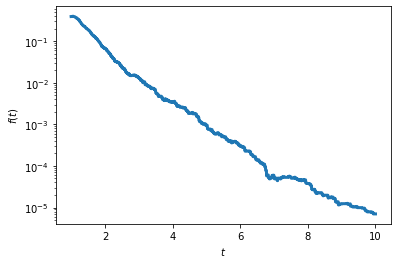

In [3]:
maximum = 10000

# The vectors of Eq. S9
Pvec = np.zeros(maximum)
Fpsi = np.zeros(maximum)

for i in range(N):

    # Sample a diffusive trajectory from x = 1 to the origin
    x = np.array([x0] + list(np.random.normal(scale = scale, size = 999999))).cumsum()
    ni = np.argmax(x < 0) if 0 != np.argmax(x < 0) else len(x)
    x = x[:ni]
    
    p = r * (x > 1) * dt              # The probability of resetting given that no resetting occurred previously
    psi = (1 - p).cumprod() / (1 - p) # Survival probability of trajectory i through Eq. 4
    psi = psi * (psi > 0) 
    
    # Adding the contribution of trajectory i to Eq. S9
    if ni < maximum:
        Fpsi[ni] += psi[-1] / N
    Pvec += p[min([maximum,ni-1])] * psi[min([maximum,ni-1])] / N

# Filling matrix P
Pmatrix = np.zeros((maximum,maximum))
for j in range(maximum):
    for i in range(j+1,maximum):
        Pmatrix[i][j] = Pvec[i-j]
        
inversed = np.linalg.inv(np.identity(maximum) - Pmatrix) # The inverse of (I - P)
FPTdistribution = inversed.dot(Fpsi)                     # The FPT distribution through Eq. S7

plt.plot(np.linspace(1, 10, 9001), np.convolve(FPTdistribution, np.ones(1000)/1000, mode='valid')*1000, linewidth = 3) # The convolution is introduced to smoothen 
                                                                                                                       # the noisy, high resolution result
plt.xlabel(r"$t$")
plt.ylabel(r"$f(t)$")
plt.yscale("log")

## The NESS

Finally, we demonstrate how to estimate the NESS of a one-dimensional diffusion with resetting rate $r(x) = x^2$.

/tmp/ipykernel_201123/2213510696.py:20: RuntimeWarning: floating point number truncated to an integer
  ys = np.sqrt(2*abs(bins-0.001)/np.pi)/scp.special.gamma(0.25)*scp.special.kn(0.25,0.5*(bins-0.001)**2)


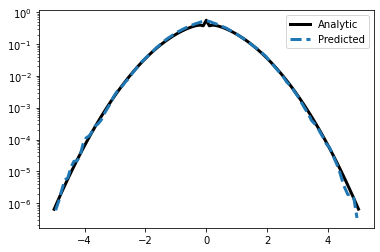

In [4]:
NESS = np.zeros(100)
bins = np.linspace(-5, 5, 101)

for i in range(N):
    
    # Sample a diffusive trajectory initiated at x = 0
    x = np.random.normal(scale=scale,size=99999).cumsum()
    
    p = x ** 2 * dt                   # The probability of resetting given that no resetting occurred previously
    psi = (1 - p).cumprod() / (1 - p) # Survival probability of trajectory i through Eq. 4
    psi = psi * (psi > 0)
    
    # Add the contribution of trajectory i to the NESS through Eq. 15
    c,b = np.histogram(x,bins = bins, weights = psi)
    NESS += c 
    
NESS = NESS / NESS.sum() / (bins[1] - bins[0]) # Normalization

ys = np.sqrt(2*abs(bins-0.001)/np.pi)/scp.special.gamma(0.25)*scp.special.kn(0.25,0.5*(bins-0.001)**2) # From ref. 24
ys[50] = 1 / np.sqrt(np.pi)

plt.plot(bins, ys, color="black", label = "Analytic", linewidth = 3) 
bins = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bins, NESS, linestyle = "dashed", label = "Predicted", linewidth = 3)
plt.yscale("log")
plt.legend()